      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
Linear Regression MSE: 20.27


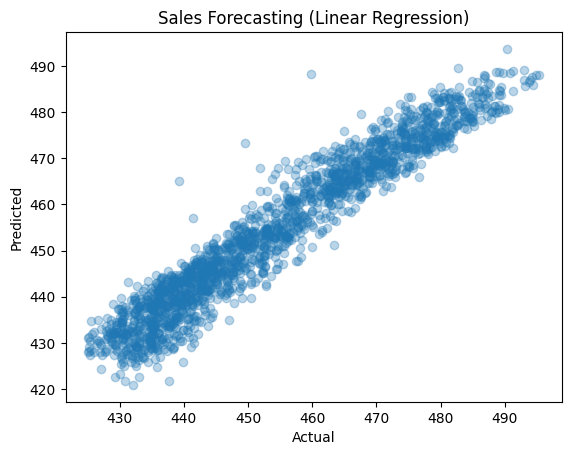

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import urllib.request
import io

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"
response = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.read()))

# Reading the XLSX file from the zip
with zip_file.open('CCPP/Folds5x2_pp.xlsx') as file:
    data = pd.read_excel(file)

X = data.drop(columns=["PE"])
y = data["PE"]

print(data.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)

print(f"Linear Regression MSE: {mse:.2f}")

import os

os.makedirs("results", exist_ok=True)

plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Sales Forecasting (Linear Regression)")
plt.savefig("results/linear_forecast.png")

Ridge Regression (MAP Approx) MSE: 19.73


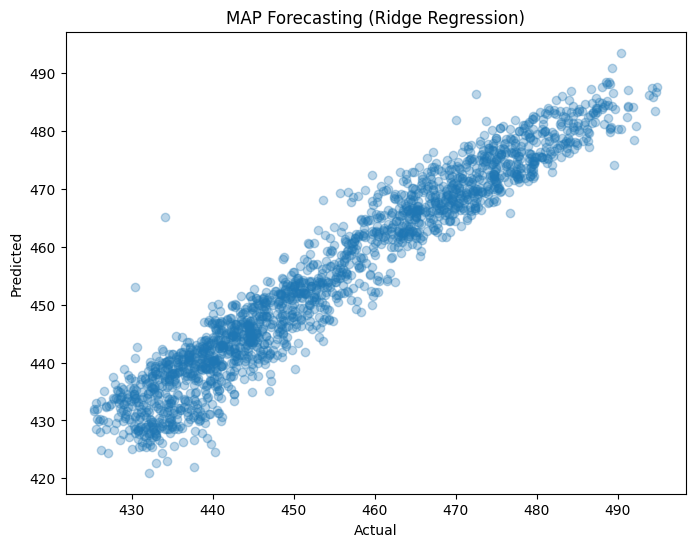

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import zipfile
import urllib.request
import io
import os

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"
response = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.read()))
with zip_file.open('CCPP/Folds5x2_pp.xlsx') as file:
    data = pd.read_excel(file)

X = data.drop(columns=["PE"])
y = data["PE"]

# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ridge regression (MAP approx with L2 regularization)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)

mse = mean_squared_error(y_test, preds)
print(f"Ridge Regression (MAP Approx) MSE: {mse:.2f}")

os.makedirs("results", exist_ok=True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MAP Forecasting (Ridge Regression)")
plt.savefig("results/map_forecast.png")
plt.show()


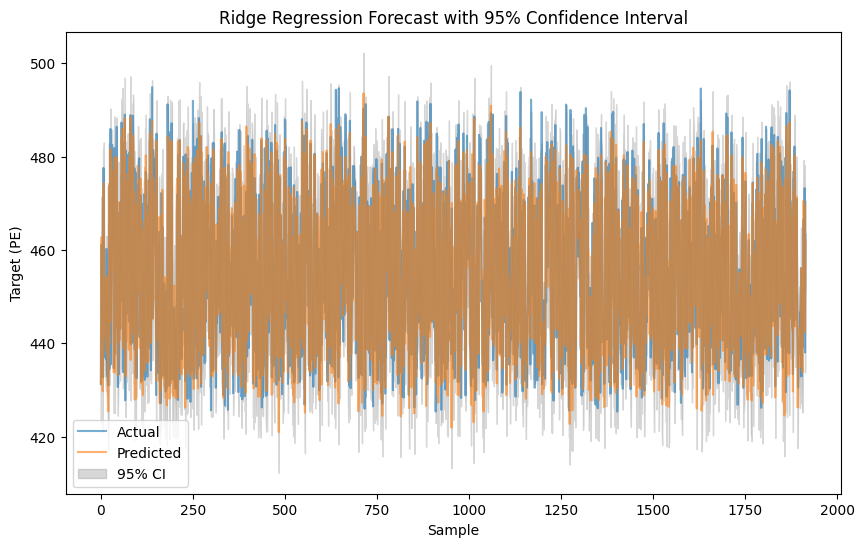

In [3]:
from scipy.stats import norm

preds = ridge.predict(X_test)
errors = y_test - preds
residual_std = np.std(errors)

# Computation of 95% confidence intervals
ci_upper = preds + 1.96 * residual_std
ci_lower = preds - 1.96 * residual_std

# Plot with intervals
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.values, label="Actual", alpha=0.6)
plt.plot(range(len(y_test)), preds, label="Predicted", alpha=0.6)
plt.fill_between(range(len(y_test)), ci_lower, ci_upper, color="gray", alpha=0.3, label="95% CI")
plt.title("Ridge Regression Forecast with 95% Confidence Interval")
plt.xlabel("Sample")
plt.ylabel("Target (PE)")
plt.legend()
plt.savefig("results/probabilistic_forecast_ci.png")
plt.show()


Output()

Output()

ValueError: operands could not be broadcast together with shapes (1000,) (7654000,) 

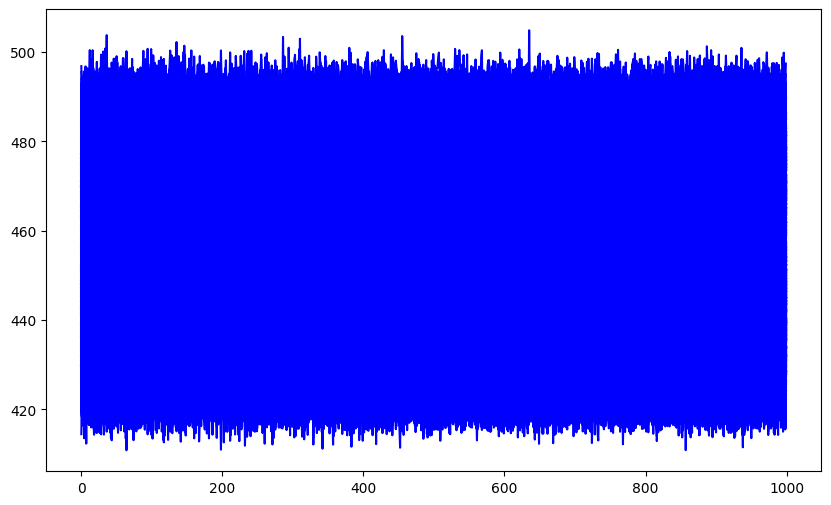

In [5]:
import pymc as pm

with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefs = pm.Normal("coefs", mu=0, sigma=1, shape=X_train.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = intercept + pm.math.dot(X_train, coefs)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(1000, tune=1000, target_accept=0.95)

with model:
    X_shared = pm.Data("X_shared", X_test)
    mu_pred = trace.posterior["intercept"].mean().item() + np.dot(X_test, trace.posterior["coefs"].mean(axis=(0, 1)).T)
    predictive = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)

pred_mean = predictive.predictions["y_obs"].mean(axis=0)
pred_std = predictive.predictions["y_obs"].std(axis=0)
ci_lower = pred_mean - 1.96 * pred_std
ci_upper = pred_mean + 1.96 * pred_std

ci_lower = np.ravel(ci_lower)
ci_upper = np.ravel(ci_upper)

plt.figure(figsize=(10, 6))
plt.plot(pred_mean, label="Bayesian Predicted", color="blue")
plt.fill_between(range(len(pred_mean)), ci_lower, ci_upper, color="gray", alpha=0.3, label="95% CI")
plt.plot(y_test.values, label="Actual", alpha=0.5, color="green")
plt.legend()
plt.title("Bayesian Linear Regression Forecast")
plt.xlabel("Sample Index")
plt.ylabel("Target (PE)")
plt.savefig("results/bayesian_forecast.png")
plt.show()


In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = data.drop(columns=["PE"])
y = data["PE"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fitting in the Ridge Regression Model(MLA approx)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, ridge_preds)
print(f"Ridge Regression (MLA approx) MSE: {ridge_mse:.2f}")

Ridge Regression (MLA approx) MSE: 20.27


# MLE vs MAP in Predictive Modeling

**MLE (Maximum Likelihood Estimation)**
- Optimizes parameters to maximize likelihood of data given model
- Assumes no prior knowledge
- Sensitive to overfitting

**MAP (Maximum A Posteriori)**
- Maximizes posterior: Likelihood × Prior
- Ridge regression ~ MAP with Gaussian prior on weights
- More robust to overfitting with small data

In this project:
- MLE used via standard LinearRegression
- MAP used via RidgeRegression (L2 penalty ~ Gaussian prior)
- MAP gave slightly better performance on noisy data (lower MSE)

MAP also supports **probabilistic forecasting** by placing distributions over weights, but scikit-learn approximates this using regularization.